## Dependencias 

In [108]:
import numpy as np 
import pandas as pd 
from CreditScoringToolkit.frequency_table import frequency_table #pip install woe-credit-scoring

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score,roc_curve

from functools import reduce

from varclushi import VarClusHi
import cufflinks as cf

cf.go_offline()

## Lectura de datos 

In [13]:
df = pd.read_sas('data/churn.sas7bdat')
print(df.shape)
df.head()

(2801, 14)


,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,b'No',b'Yes',25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,b'No',b'Yes',26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,b'No',b'No',0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,b'No',b'No',0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,b'No',b'No',0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Limpieza 

### Categorización de variables 

In [14]:
varc = [v for v in df.columns if v[:2]=='V_']
vard = [v for v in df.columns if v[:2]=='C_']
vart = ['TARGET']
um = ['ID']

### Reasignar etiquetas de variables discretas 

In [15]:
for v in vard:
    df[v] = (df[v] == b'Yes').astype(float)

In [16]:
df.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,0.0,1.0,25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,0.0,1.0,26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,0.0,0.0,0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,0.0,0.0,0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,0.0,0.0,0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Partición

In [27]:
rs = np.random.RandomState(20240905)

In [28]:
train,valid =train_test_split(df[um+vart+vard+varc],
                              train_size=0.7,
                              random_state=rs)

In [29]:
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)   

In [30]:
train.shape,valid.shape

((1960, 14), (841, 14))

## Análisis exploratorio de datos 

In [32]:
frequency_table(train,vart)
frequency_table(valid,vart)

****Frequency Table  TARGET  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0.0        1693    0.863776              1693          0.863776
1.0         267    0.136224              1960          1.000000




****Frequency Table  TARGET  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0.0         729    0.866825               729          0.866825
1.0         112    0.133175               841          1.000000






### Discreto

In [31]:
frequency_table(train,vard)

****Frequency Table  C_IP  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0.0        1755    0.895408              1755          0.895408
1.0         205    0.104592              1960          1.000000




****Frequency Table  C_VMP  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0.0        1422     0.72551              1422           0.72551
1.0         538     0.27449              1960           1.00000






### Continuo

#### Ausentes 

In [33]:
miss = train[varc].isna().sum()
miss 

V_ACCT_LGHT      0
V_N_VM_MESS      0
V_T_DAY_CHG      0
V_T_EVE_CALLS    0
V_T_EVE_CHG      0
V_T_NIG_CALLS    0
V_T_NIG_CHG      0
V_T_INT_CALLS    0
V_T_INT_CHG      0
V_CS_CALLS       0
dtype: int64

#### Distribución

array([[<Axes: title={'center': 'V_ACCT_LGHT'}>,
        <Axes: title={'center': 'V_N_VM_MESS'}>,
        <Axes: title={'center': 'V_T_DAY_CHG'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_EVE_CHG'}>,
        <Axes: title={'center': 'V_T_NIG_CALLS'}>],
       [<Axes: title={'center': 'V_T_NIG_CHG'}>,
        <Axes: title={'center': 'V_T_INT_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>],
       [<Axes: title={'center': 'V_CS_CALLS'}>, <Axes: >, <Axes: >]],
      dtype=object)

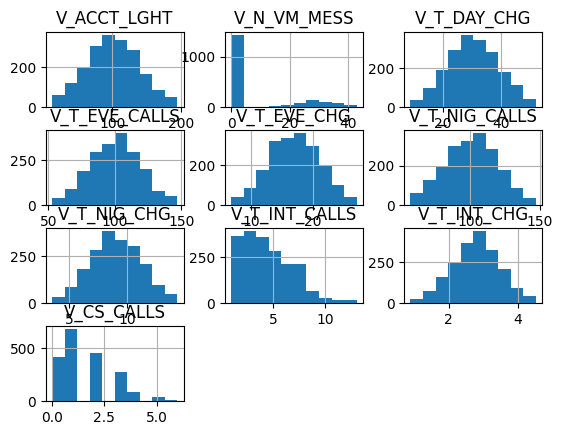

In [34]:
train[varc].hist()

#### Extremos 

In [49]:
# Cerca percentil
for v,li,ls in train[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1)
frequency_table(train,'ex_')
train.drop('ex_',axis=1,inplace=True)

# Rango inter-cuartil

k = 3 # 2 = moderado, 3 = extremo
iqr = train[varc].describe().T[['25%','75%','mean']]
iqr['iqr'] = iqr['75%']-iqr['25%']
iqr['li'] = iqr['mean']-k*iqr['iqr']
iqr['ls'] = iqr['mean']+k*iqr['iqr']
iqr = iqr[['li','ls']].reset_index()

for v,li,ls in iqr.values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1)
frequency_table(train,'ex_')


****Frequency Table  ex_  ***


   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0        1629    0.831122              1629          0.831122
1         331    0.168878              1960          1.000000




****Frequency Table  ex_  ***


   Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
0        1910     0.97449              1910           0.97449
1          50     0.02551              1960           1.00000






In [51]:
train = train.loc[train['ex_']==0].reset_index(drop=True)

array([[<Axes: title={'center': 'V_ACCT_LGHT'}>,
        <Axes: title={'center': 'V_N_VM_MESS'}>,
        <Axes: title={'center': 'V_T_DAY_CHG'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_EVE_CHG'}>,
        <Axes: title={'center': 'V_T_NIG_CALLS'}>],
       [<Axes: title={'center': 'V_T_NIG_CHG'}>,
        <Axes: title={'center': 'V_T_INT_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>],
       [<Axes: title={'center': 'V_CS_CALLS'}>, <Axes: >, <Axes: >]],
      dtype=object)

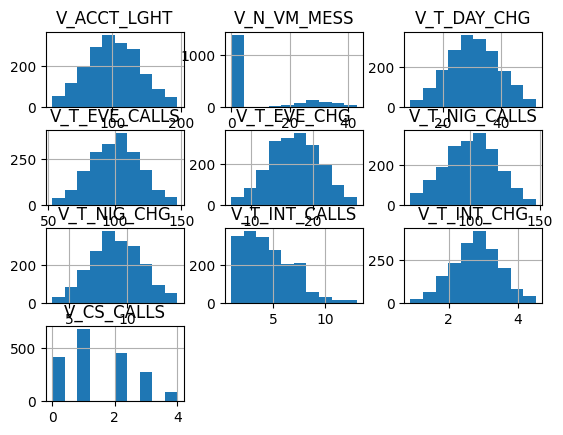

In [52]:
train[varc].hist()

#### Multicolinealidad

In [55]:
vc = VarClusHi(df=train,feat_list=varc)
vc.varclus()


In [57]:
vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
1,0,V_T_EVE_CHG,0.411918,0.000289,0.588252
0,0,V_N_VM_MESS,0.342982,0.000143,0.657112
2,0,V_CS_CALLS,0.298766,0.000317,0.701456
3,1,V_ACCT_LGHT,0.523840,0.000542,0.476419
4,1,V_T_EVE_CALLS,0.523840,0.000586,0.476440
5,2,V_T_DAY_CHG,0.510735,0.000219,0.489372
6,2,V_T_INT_CHG,0.293141,0.000146,0.706962
7,2,V_T_NIG_CALLS,0.236210,0.000489,0.764164
8,3,V_T_NIG_CHG,0.508442,0.000255,0.491683
9,3,V_T_INT_CALLS,0.508442,0.000796,0.491950


In [58]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
mc

['V_T_EVE_CHG', 'V_ACCT_LGHT', 'V_T_DAY_CHG', 'V_T_NIG_CHG']

array([[<Axes: title={'center': 'V_T_EVE_CHG'}>,
        <Axes: title={'center': 'V_ACCT_LGHT'}>],
       [<Axes: title={'center': 'V_T_DAY_CHG'}>,
        <Axes: title={'center': 'V_T_NIG_CHG'}>]], dtype=object)

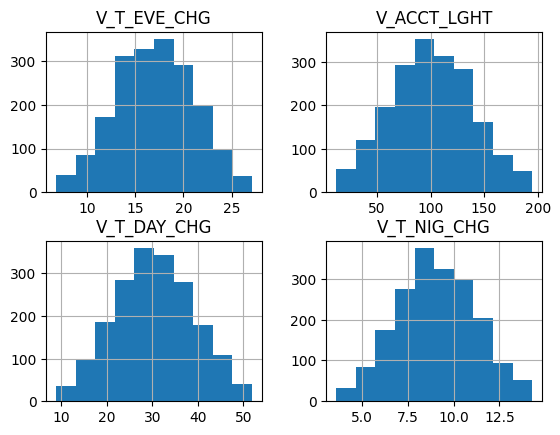

In [60]:
train[mc].hist()

### Poder predictivo

In [74]:
sk = SelectKBest(k=len(mc)+len(vard))
sk.fit(train[mc+vard],train[vart[0]])

SelectKBest(k=6)

In [75]:
pd.Series(dict(zip(sk.feature_names_in_,sk.scores_))).sort_values(ascending=False).iplot(kind='bar',color='purple')

In [78]:
sk = SelectKBest(k=4)
sk.fit(train[mc+vard],train[vart[0]])

SelectKBest(k=4)

In [79]:
best = [v for v,s in zip(sk.feature_names_in_,sk.get_support()) if s]
best

['V_T_EVE_CHG', 'V_T_DAY_CHG', 'C_IP', 'C_VMP']

## Aprendizaje

In [114]:
ann = MLPClassifier()

#### Híper-parametrización 

In [115]:
hp = {
    'hidden_layer_sizes': [(a,b,) for a in range(1,11) for b in range(1,11) ],
    'activation': ['relu', 'tanh', 'logistic','identity'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter': [1000]
}

In [116]:
reduce(lambda x,y:x*y,map(len,hp.values()))

3600

In [117]:
grid = RandomizedSearchCV(ann,
                          param_distributions=hp,
                          n_iter=50,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True)

In [118]:
grid.fit(train[best],train[vart[0]])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/josegustavofuentescabrera/entornos/plurall/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/josegustavofuentescabrera/entornos/plurall/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic', 'identity'],
                                        'hidden_layer_sizes': [(1, 1), (1, 2),
                                                               (1, 3), (1, 4),
                                                               (1, 5), (1, 6),
                                                               (1, 7), (1, 8),
                                                               (1, 9), (1, 10),
                                                               (2, 1), (2, 2),
                                                               (2, 3), (2, 4),
                                                               (2, 5), (2, 6),
                                                               (2, 7), (2, 8),
                                                               (2, 9), (2, 10),
                                                               (3, 1), (3, 2),
                                                               (3, 3), (3, 4),
                                                               (3, 5), (3, 6),
                                                               (3, 7), (3, 8),
                                                               (3, 9), (3, 10), ...],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='roc_auc', verbose=True)

In [119]:
ann = grid.best_estimator_
ann

MLPClassifier(activation='logistic', hidden_layer_sizes=(8, 5),
              learning_rate='adaptive', max_iter=1000, solver='lbfgs')

In [120]:
grid.best_score_,grid.best_params_

(0.7895839949190219,
 {'solver': 'lbfgs',
  'max_iter': 1000,
  'learning_rate': 'adaptive',
  'hidden_layer_sizes': (8, 5),
  'activation': 'logistic'})

### Estimación de parámetros $\vec{\theta}$

In [121]:
ann.fit(train[best],train[vart[0]])

MLPClassifier(activation='logistic', hidden_layer_sizes=(8, 5),
              learning_rate='adaptive', max_iter=1000, solver='lbfgs')

### Validación de modelo

In [122]:
{'train': roc_auc_score(y_true=train[vart[0]],y_score=ann.predict_proba(train[best])[:,1]),
 'valid': roc_auc_score(y_true=valid[vart[0]],y_score=ann.predict_proba(valid[best])[:,1])
 }

{'train': 0.8115211178151793, 'valid': 0.7949123064863804}

## Reportes del modelo

In [130]:
train['proba'] = ann.predict_proba(train[best])[:,1]
valid['proba'] = ann.predict_proba(valid[best])[:,1]

In [144]:
train['r_proba'] = pd.cut(train['proba'],bins=np.arange(0,0.8,0.2),include_lowest=True).astype(str)
valid['r_proba'] = pd.cut(valid['proba'],bins=np.arange(0,0.8,0.2),include_lowest=True).astype(str)

In [156]:
pd.concat([train[vart+['r_proba']+um].groupby(vart+['r_proba']).count().reset_index().assign(muestra='train'),
valid[vart+['r_proba']+um].groupby(vart+['r_proba']).count().reset_index().assign(muestra='valid')],ignore_index=True).to_clipboard(index=False)

In [157]:
best


['V_T_EVE_CHG', 'V_T_DAY_CHG', 'C_IP', 'C_VMP']